# Step-by-step Guide: Constructing a model with Phydrus for COSMOS-UK Sites

*Authors: Michael Tso (UKCEH)* 

*Based on Step-by-step Guide: Constructing a model with Phydrus by R.A. Collenteur & M. Vremec* 

The original notebook is part of a manuscript that is currently being prepared (spring 2020): 

*R.A. Collenteur, G. Brunetti, M. Vremec & J. Simunek (in preparation) Phydrus: a Python implementation of the Hydrus-1D model.*

[EGU 2020 summary slides](https://presentations.copernicus.org/EGU2020/EGU2020-15377_presentation.pdf)
---

This Notebook presents the basics steps to create a Phydrus model simulating water flow through the vadose zone. In the presented example, the workflow is divided into several steps, to demonstrate the usage of Phydrus methods:
1. Import the Phydrus package
2. Create the basic model
3. Add processes and materials
4. Add soil profile
5. Add Root Water Uptake
6. Add atmospheric boundary condition
7. Add observations nodes
8. Simulate the model
9. Post-process the results
___
### Installing hydrus
The hydrus program that simulates water flow is a FORTRAN program. You will need to compile the source code. See https://github.com/phydrus/phydrus#2-compiling-the-source-code.

In a jupyter notebook, run the following when you use phydrus for the first time (this first steps may need to be repeated whenever DataLabs is being updated):

1. Open a Linux terminal, run `sudo apt update`
2. In the terminal, run `sudo apt install gfortran`
3. Download the hydrus source code and go to the `source_code` directory. Type `make` in the terminal. The resultant executable is `phydrus`
4. Move the `phydrus` executable to a different folder if desired. Make sure the path to it is correctly specified in `exe = ...` in one of the celss below.


If everything works well, you will see `INFO: Hydrus-1D Simulation Successful.` when you run `ml.simulate()`,
___
### Getting COSMOS-UK data
This notebooks follows closely the methods in [Beale et al. (2021)](https://doi.org/10.1109/JSTARS.2021.3071380). PET is separated to PE and PT based on MODIS leaf area index (LAI), which was extracted on Google Earth Engine and is exported as a csv file. Other variables, including PE(T), rainfall, and COSMOS-UK are retrieved using the COSMOS-UK data application programming interface (API): https://cosmos-api.ceh.ac.uk/.

In this notebook, the data extraction was performed by a helper class called `CosmosData`.
___

### 1. Import the Pydrus package

** Index:**

### [8. Simulate the model](#the_destination)

# TODO:

1. Get observed data (post-analysis notebook)
2. New notebook to prep atmo data from GEE
3. Change profile to match JULES


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

import ipywidgets as widgets


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import phydrus as ps

from sm_utils import CosmosData # my tools

os.getcwd()

'/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS'

### 2. Create the basic model & add time information
In the code block below a `Model` instance is created. The path to the Hydrus-1D executable has to be set at this stage. Phydrus will check the executable, and raise an Error if it is not found. 

In [2]:
#site = sitechoice.value
site='CHIMN' ## problems: EUSTON, SPRNF
CD1 = CosmosData(years=[2016,2017,2018,2019],site=site) # all object to grab all required input data


LAI
https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z
printing atmo API data.
printing atmo data.


In [3]:
#Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "../../hydrus")

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="model",
              time_unit="days", length_unit="cm")

ml.add_time_info(tinit=0, tmax=len(CD1.driving_data),print_times=True,dtprint=1);

### 3. Add processes and materials
In this step a model for the water flow is selected and top and bottom boundary conditions, using the ml.add_waterflow method. After that, we can use the get_empty_material_df method to obtain an empty DataFrame to define our soil hydraulic parameters for the different soil materials. In this example, the model contains to soil materials. The hydraulic parameters here are identical to those used in [Beale et al. (2021)](https://doi.org/10.1109/JSTARS.2021.3071380).

In [4]:
mat_cosmos = pd.DataFrame({'SITE_ID': ['CARDT','CGARW','CHIMN','ELMST','EUSTON','FINCH','HADLW','HYBRY','LODTN','RISEH','ROTHD','SPRNF','WRTTL'],\
                          'thr':[9.59,9.0,11.36,7.32,7.31,7.71,12.22,13.47,11.35,14.59,7.46,9.34,7.65],\
                          'ths':[48.36,90.0,54.56,32.5,45.21,36.98,57.47,69.09,44.09,72.3,33.9,40.33,35.38],\
                          'Alfa':[0.0492,0.1158,0.054,0.0591,0.0908,0.0784,0.0441,0.0406,0.0384,0.0468,0.0406,0.051,0.0489],\
                          'n':[1.2438,1.383,1.2326,1.2488,1.348,1.2984,1.2229,1.2321,1.2321,1.2247,1.2385,1.2387,1.2483],\
                          'Ks':[109.3,6540.5,101.4,76.4,115.5,92.05,105.3,117.6,71.5,107.3,107.3,76.4,76.4]\
                          }).set_index('SITE_ID')\
            .assign(l=lambda x: 0.5)\
            .assign(ths=lambda x: 0.01*x['ths'])\
            .assign(thr=lambda x: 0.01*x['thr'])\

mat_cosmos

,thr,ths,Alfa,n,Ks,l
SITE_ID,,,,,,
CARDT,0.0959,0.4836,0.0492,1.2438,109.30,0.5
CGARW,0.0900,0.9000,0.1158,1.3830,6540.50,0.5
CHIMN,0.1136,0.5456,0.0540,1.2326,101.40,0.5
ELMST,0.0732,0.3250,0.0591,1.2488,76.40,0.5
EUSTON,0.0731,0.4521,0.0908,1.3480,115.50,0.5
FINCH,0.0771,0.3698,0.0784,1.2984,92.05,0.5
HADLW,0.1222,0.5747,0.0441,1.2229,105.30,0.5
HYBRY,0.1347,0.6909,0.0406,1.2321,117.60,0.5
LODTN,0.1135,0.4409,0.0384,1.2321,71.50,0.5


In [5]:

ml.add_waterflow(model=0, top_bc=3, bot_bc=4) # top3 = Atmospheric Boundary Condition with Surface Run Off. bot4 = free drainage
m = ml.get_empty_material_df(n=3)
m.loc[0:3] = [mat_cosmos.loc[site].values.tolist(),#columns=["thr", "ths", "Alfa", "n" "Ks", "l"]
              mat_cosmos.loc[site].values.tolist(),
              mat_cosmos.loc['WRTTL'].values.tolist()]
# m.loc[0:2] = [[0.0, 0.3382, 0.0111, 1.4737, 13, 0.5],  #columns=["thr", "ths", "Alfa", "n" "Ks", "l"]
#               [0.0, 0.3579, 0.0145, 1.5234, 50, 0.5]]
ml.add_material(m)
m

water                                    
      thr     ths    Alfa       n     Ks    l
1  0.1136  0.5456  0.0540  1.2326  101.4  0.5
2  0.1136  0.5456  0.0540  1.2326  101.4  0.5
3  0.0765  0.3538  0.0489  1.2483   76.4  0.5

### 4. Add Profile information
We develop the linear function of potential root water uptake distribution  $S^*_{p}(z)$ vs depth, following Hoffman and van Genuchten. 


\begin{equation}
S^*_{p} = \left \{
\begin{aligned}
&1 && \text{for} && z>L-r_1 \\
&\frac{z-[L-(r_1 + r_2)]}{r_2} && \text{for} && L-r_1 \geq z \geq L-(r_1 + r_2) \\
&0 && \text{for} && L-r_1 z < L-(r_1 + r_2) 
\end{aligned} \right.
\end{equation} 

In [6]:
# Define loop for potential root water uptake distribution proposed by Hoffman and Van Genuchten
def z_loop(z, r1 = 10, r2 = 20):
    if z > -r1:
        return 1
    elif z < -(r1 + r2):
        return 0
    else:
        return(z+(r1+r2))/r2

bottom = [-30, -50, -100 ]  # Depth of the soil column -100, -300
nodes = 150  # Dictretize into n nodes
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, mat=[1,2,3])
profile["Beta"] = profile.apply(lambda row: z_loop(row["x"]), axis=1)
ml.add_profile(profile)

In [7]:
ml.materials[('water','l')] = 0.5
ml.materials['water', 'mat'] = [0, 1, 2]
ml.materials


water                                        
      thr     ths    Alfa       n     Ks    l mat
1  0.1136  0.5456  0.0540  1.2326  101.4  0.5   0
2  0.1136  0.5456  0.0540  1.2326  101.4  0.5   1
3  0.0765  0.3538  0.0489  1.2483   76.4  0.5   2

<AxesSubplot:xlabel='h [cm]', ylabel='depth [cm]'>

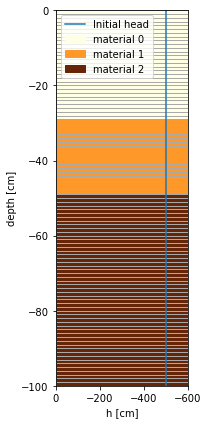

In [8]:
ml.plots.profile(figsize=(3,6), color_by="mat")

array([<AxesSubplot:xlabel='h', ylabel='theta'>,
       <AxesSubplot:xlabel='log_h'>], dtype=object)

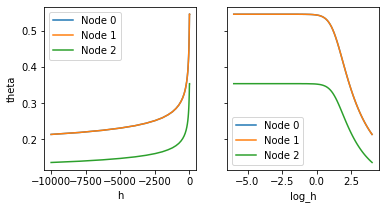

In [9]:
ml.plots.soil_properties("Water Content")

<AxesSubplot:xlabel='h [cm]', ylabel='Depth [cm]'>

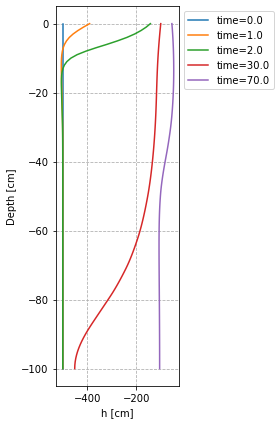

In [10]:
ml.plots.profile_information(figsize=(4,6), times=[0,1,2,30,70])

<AxesSubplot:>

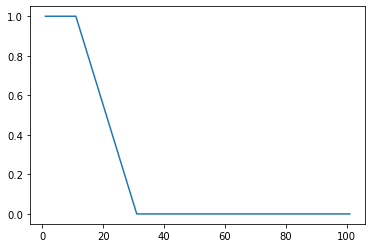

In [11]:
profile['Beta'].plot()

### 5. Add atmosphere boundary conditions
Atmospheric boundary condition can be added easily by reading in a CSV file using Pandas `read_csv` method and adding it to the model. 

In [12]:
# ET: https://github.com/phydrus/phydrus/issues/5
atm = pd.read_csv("data/atmosphere_API.csv", index_col=0)
#atm = atm.reset_index().drop(columns='Date')
ml.add_atmospheric_bc(atm, hcrits=0)

### 6. Add root water uptake

In [14]:
ml.add_root_uptake(model=0, p2h=-1500, p2l=-1500, poptm=[-25, -25, -25])

### 7. Add observation nodes

In [15]:
#Number of the node -- > write script to get node closest to desired depth
ml.add_obs_nodes([-5,-30])

### 8. Write hydrus input files & run hydrus 
Before we can simulate, we write all model information to files. 

In [16]:
atm

,tAtm,Prec,rSoil,rRoot,hCritA
0,1,0.11,0.0303,0.0097,100000
1,2,0.38,0.0255,0.0045,100000
2,3,0.74,0.0382,0.0018,100000
3,4,0.11,0.0668,0.0032,100000
4,5,0.07,0.0191,0.0009,100000
...,...,...,...,...,...
1456,1457,0.00,0.0065,0.0035,100000
1457,1458,0.00,0.0120,0.0080,100000
1458,1459,0.00,0.0059,0.0041,100000
1459,1460,0.00,0.0175,0.0125,100000


In [17]:
%%time

ml.write_input()
ml.simulate()

INFO: Successfully wrote output/SELECTOR.IN
INFO: Successfully wrote output/PROFILE.DAT
INFO: Successfully wrote output/ATMOSPH.IN
INFO: Hydrus-1D Simulation Successful.


CPU times: user 165 ms, sys: 9.77 ms, total: 175 ms
Wall time: 1.98 s


CompletedProcess(args=['/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS/../../hydrus', 'output', '-1'], returncode=0)

### 9a. Plot results
Plot pressure for soil column at the end of the simulation.
- Wilting point h=-8000
- Field capactiy h=-33kPa = -10.197 cmH2O

In [18]:



from scipy import interpolate

lines = ml.plots.soil_properties(figsize=(6, 2.5))
plt.close()
x = lines[0].get_children()[0].get_data()[0]
y = lines[0].get_children()[0].get_data()[1]
#print('Field_capacitiy=',interpolate.interp1d(x, y)(-10.197))

### 9b. Plot the drainage over time

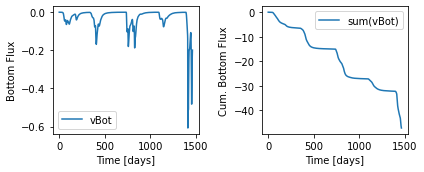

In [19]:


axes = ml.plots.water_flow("Bottom Flux", figsize=(6, 2.5))
#plt.savefig("../../figures/water_flow.eps", bbox_inches="tight", dpi=300)

### 9c. Plot the water content over time

Text(0.5, 6.000000000000025, '')

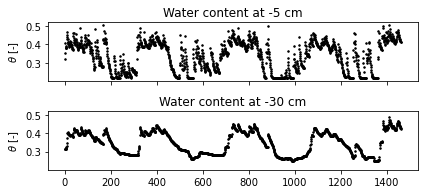

In [20]:
df = ml.read_obs_node()
fig, [ax0, ax1] = plt.subplots(2,1, figsize=(6,3), sharex=True, sharey=True)
df[ml.obs_nodes[0]]["theta"].plot(ax=ax0, marker=".", c="k", linestyle="", markersize=3)
ax0.set_title("Water content at -5 cm")
ax0.set_ylabel(r"$\theta$ [-]")

df[ml.obs_nodes[1]]["theta"].plot(ax=ax1, marker=".", c="k", linestyle="", markersize=3)
ax1.set_title("Water content at -30 cm")
ax1.set_ylabel(r"$\theta$ [-]")
plt.tight_layout()
ax1.set_xlabel("")
#ax1.set_xlim(0,730)
#ax1.set_xticks([0,365,730])
#ax1.set_xticklabels(["Jan-07", "Jan-08", "Jan-09"])
#plt.savefig("../../figures/water_content.eps", bbox_inches="tight", dpi=300)

In [21]:
df[ml.obs_nodes[0]].to_csv("../data/wc_5cm.csv")
df[ml.obs_nodes[1]].to_csv("../data/wc_30cm.csv")

In [22]:
df[ml.obs_nodes[0]] \
    .assign(Date=lambda x: CD1.cosmos_data.index).set_index('Date')

,h,theta,Temp
Date,,,
2016-01-01,-453.21,0.3185,20.0
2016-01-02,-220.42,0.3548,20.0
2016-01-03,-85.62,0.4086,20.0
2016-01-04,-120.52,0.3881,20.0
2016-01-05,-135.76,0.3816,20.0
...,...,...,...
2019-12-27,-64.45,0.4255,20.0
2019-12-28,-69.78,0.4207,20.0
2019-12-29,-73.76,0.4172,20.0


In [23]:
CD1.cosmos_data = CD1.cosmos_data\
    .join(df[ml.obs_nodes[0]].assign(Date=lambda x: CD1.cosmos_data.index, theta=lambda x: x.theta*100).drop(columns=['h','Temp']).rename(columns={'theta':'hydrus_5cm'}).set_index('Date'))\
    .join(df[ml.obs_nodes[1]].assign(Date=lambda x: CD1.cosmos_data.index, theta=lambda x: x.theta*100).drop(columns=['h','Temp']).rename(columns={'theta':'hydrus_30cm'}).set_index('Date'))



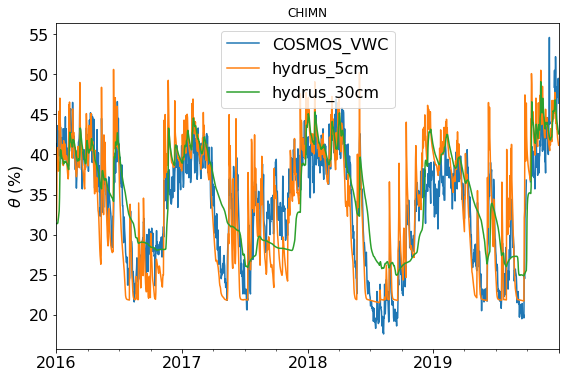

In [24]:
CD1.cosmos_data.plot(title=site, fontsize=16, figsize=(9,6))
plt.legend(fontsize = 16), plt.ylabel(r'$\theta$ (%)',fontsize = 16), plt.xlabel('')
plt.savefig('img/'+site+'.png')

(<matplotlib.legend.Legend at 0x7f015072bd00>,
 Text(0, 0.5, 'mm'),
 Text(0.5, 0, ''))

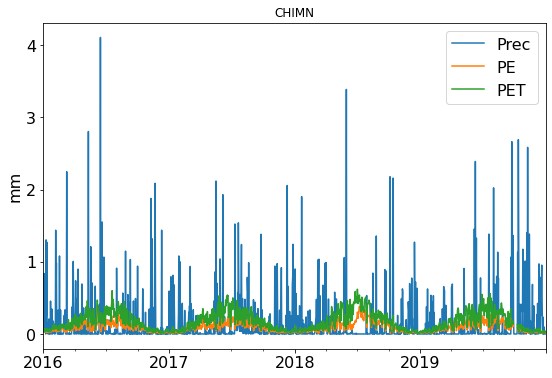

In [25]:
CD1.atmo_data.assign(Date=lambda x: CD1.cosmos_data.index, PE=lambda x: x.rSoil , PET=lambda x: x.rRoot+x.rSoil ).set_index('Date')\
    .plot(y=['Prec','PE','PET'], fontsize=16, figsize=(9,6), title=site,ylabel='mm')
plt.legend(fontsize = 16), plt.ylabel('mm',fontsize = 16), plt.xlabel('')


### 9c. Update the soil profile plot with the pressure head

In [26]:
atm

,tAtm,Prec,rSoil,rRoot,hCritA
0,1,0.11,0.0303,0.0097,100000
1,2,0.38,0.0255,0.0045,100000
2,3,0.74,0.0382,0.0018,100000
3,4,0.11,0.0668,0.0032,100000
4,5,0.07,0.0191,0.0009,100000
...,...,...,...,...,...
1456,1457,0.00,0.0065,0.0035,100000
1457,1458,0.00,0.0120,0.0080,100000
1458,1459,0.00,0.0059,0.0041,100000
1459,1460,0.00,0.0175,0.0125,100000


<AxesSubplot:xlabel='h [cm]', ylabel='depth [cm]'>

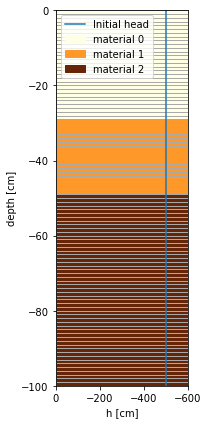

In [38]:
head = ml.read_nod_inf(times=[0]).iloc[:, 2]
ml.profile.loc[:, "h"] = head
ml.plots.profile(color_by="mat")


the_destination <a id='the_destination'></a>